Strategia inwestycyjna (decyzje wejścia i wyjścia) dla spółki  Microsoft (MSFT), 

test w okresie od 01.01.2024 - 06.05.2024



Stwórz model generujący sygnały kupna i sprzedaży na rynku

Decyzje ma generować jeden z algorytmów uczenia maszynowego, po optymalizacji hiperparametrów

Zrób backtest wybranego modelu, użyj biblioteki przystosowanej do backtestów

Pamiętaj o wnioskach i wizualizacji wyników

4 pkt z oceny będą zależne od wyników inwestycji

Inwestujesz w wylosowaną spółkę przez określony okres, ale można wykorzystać także inne dane niż historyczne (np. obliczone wskaźniki)


In [1]:
import ffn # http://pmorissette.github.io/ffn/index.html

import yfinance as yf
import datetime as dt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox

from backtesting.lib import SignalStrategy, TrailingStrategy
from backtesting import *

import simpful as sf
from simpful import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam


Loading BokehJS ...

#### Pobranie szeregu czasowego

In [2]:
start_date = dt.datetime(2019,1,1) # (RRR-MM-DD)
end_date = dt.datetime(2024,5,6)

#loading from yahoo finance
data = yf.download("MSFT",start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,1344.00,1344.00,1344.00,1344.00,1344.00,1344.00
mean,247.10,249.58,244.53,247.17,242.12,28966463.84
std,81.66,82.23,80.96,81.62,82.83,12202819.08
min,99.55,100.19,97.20,97.40,92.15,8989200.00
25%,182.82,184.41,181.10,182.90,176.33,21330750.00
50%,247.80,250.96,245.81,248.38,244.38,25991200.00
75%,304.31,308.28,301.49,304.44,298.02,33068725.00
max,429.83,430.82,427.16,429.37,428.60,97012700.00


Spółka wypłacała dywidendę, jednak do stworzenia i testowania strategii nie będę używać danych po korekcie.  

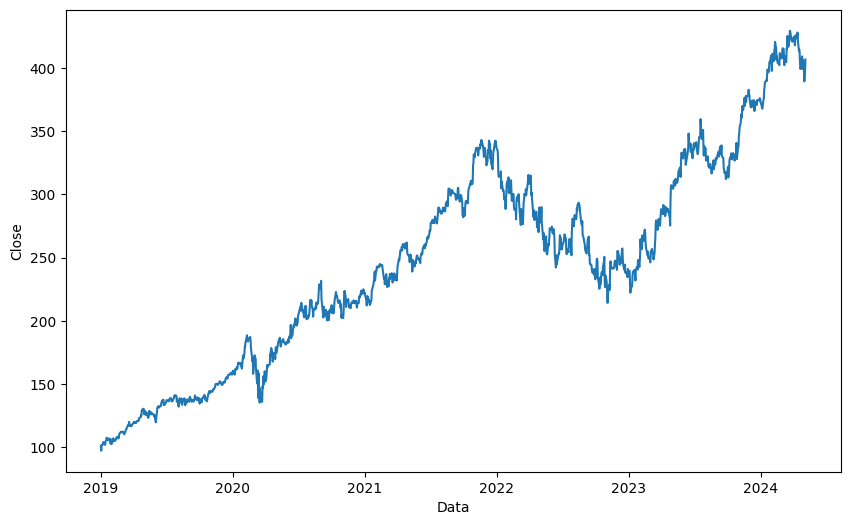

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

### Dane testowe

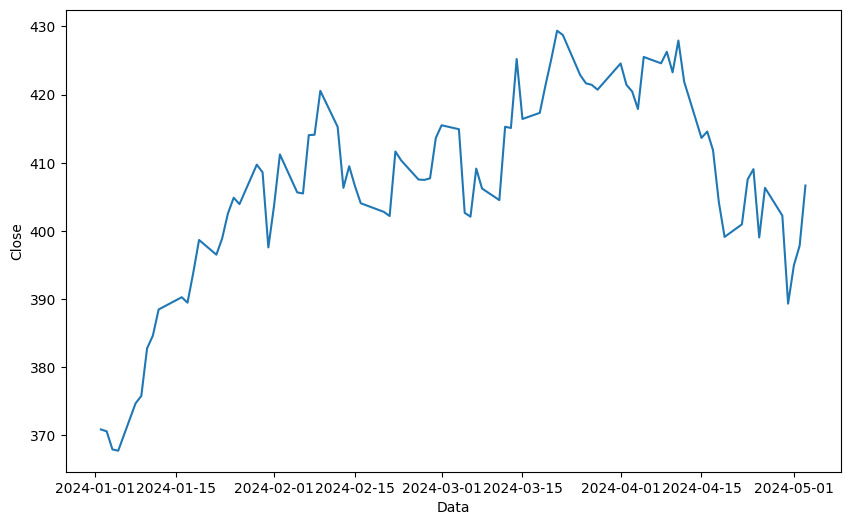

In [5]:
test_start = dt.datetime(2024,1,1) # (RRR-MM-DD)
test_end = dt.datetime(2024,5,6)

test_data = data.loc[(data.index >= test_start) & (data.index <= test_end)]
plt.figure(figsize=(10, 6))
plt.plot(test_data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

## Dane treningowe


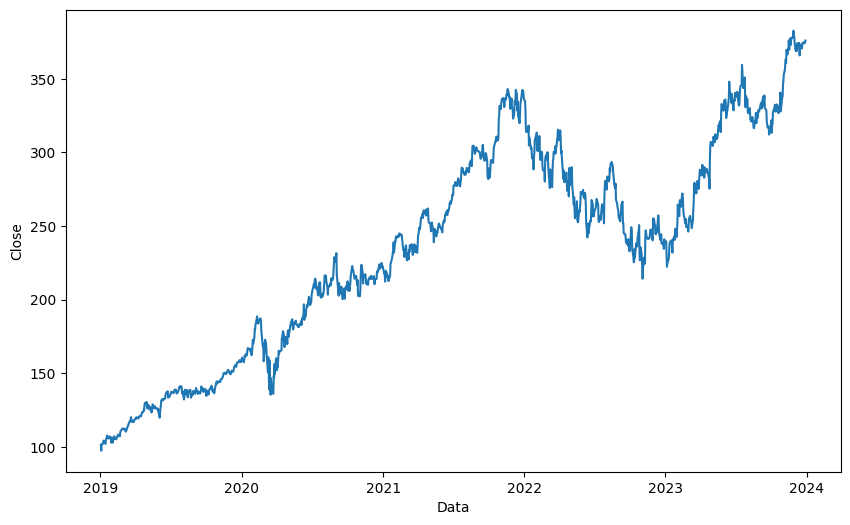

In [6]:
train_start = dt.datetime(2019,1,1)
train_end = dt.datetime(2024,1,1)

train_data = data.loc[(data.index >= train_start) & (data.index <= train_end)]
plt.figure(figsize=(10, 6))
plt.plot(train_data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

### Zwroty
Używam zwrotów logarytmicznych, ponieważ są bardziej odporne na wahanai i wartości odstające.

In [7]:
data['returns'] = data['Close'].to_log_returns()
data = data.dropna()

# Testy biblioteki 'ffn'

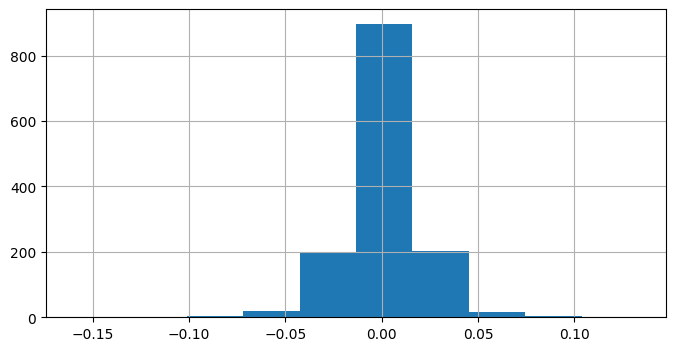

In [8]:
ax = data['returns'].hist(figsize=(8, 4))

#### Porównanie z indeksem NASDAQ (^IXIC)

In [9]:
df = ffn.get('^IXIC:Close, MSFT:Close', start=train_start, end=train_end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
returns = df.to_log_returns().dropna()
print(returns.head())

            ixicclose  msftclose
Date                            
2019-01-03  -0.030840  -0.037482
2019-01-04   0.041720   0.045460
2019-01-07   0.012477   0.001275
2019-01-08   0.010718   0.007225
2019-01-09   0.008673   0.014198


In [11]:
df.head()

,ixicclose,msftclose
Date,,
2019-01-02,6665.939941,101.120003
2019-01-03,6463.500000,97.400002
2019-01-04,6738.859863,101.930000
2019-01-07,6823.470215,102.059998
2019-01-08,6897.000000,102.800003


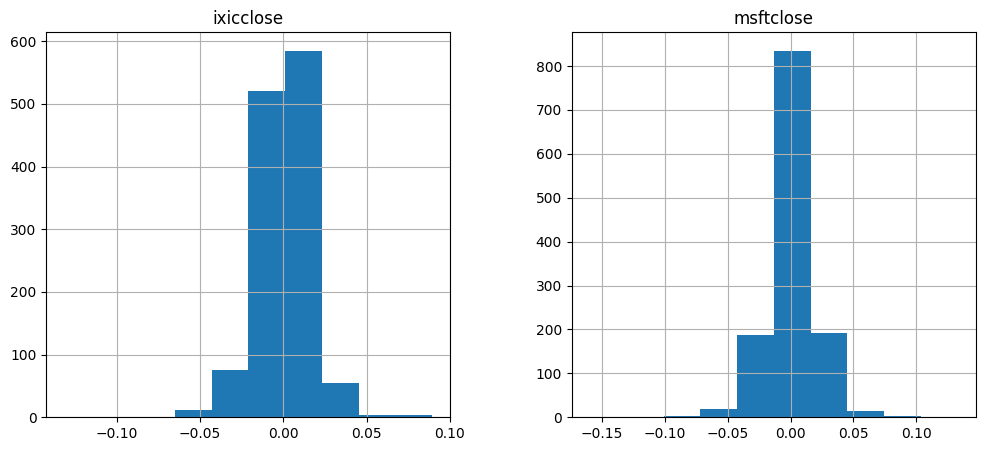

In [12]:
ax2 = returns.hist(figsize=(12, 5))

In [13]:
returns.corr().as_format('.2f')

,ixicclose,msftclose
ixicclose,1.00,0.88
msftclose,0.88,1.00


<Axes: xlabel='Date'>

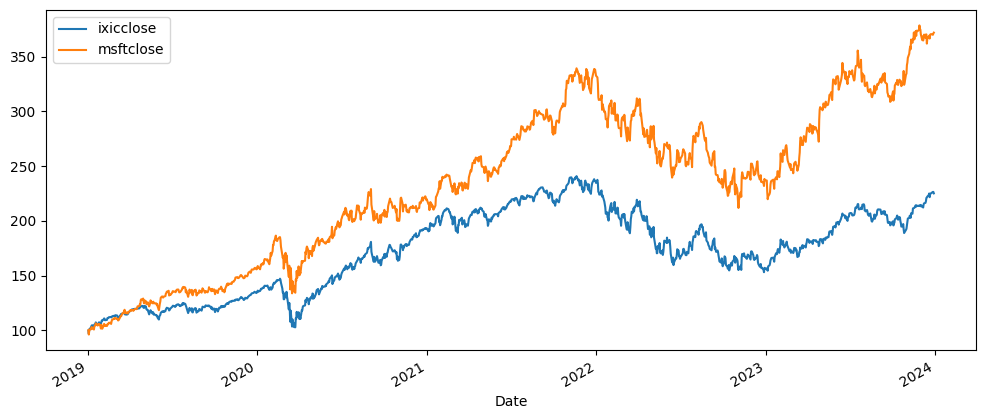

In [14]:
df.rebase().plot(figsize=(12,5))

Widać wysoką korelację pomiędzy szeregami

In [15]:
perf = df.calc_stats()
perf.display()

Stat                 ixicclose    msftclose
-------------------  -----------  -----------
Start                2019-01-02   2019-01-02
End                  2023-12-29   2023-12-29
Risk-free rate       0.00%        0.00%

Total Return         125.19%      271.87%
Daily Sharpe         0.77         1.02
Daily Sortino        1.22         1.70
CAGR                 17.67%       30.12%
Max Drawdown         -36.40%      -37.56%
Calmar Ratio         0.49         0.80

MTD                  5.52%        -0.76%
3m                   13.56%       19.09%
6m                   10.45%       12.23%
YTD                  43.42%       56.80%
1Y                   43.26%       56.03%
3Y (ann.)            5.32%        18.84%
5Y (ann.)            17.67%       30.12%
10Y (ann.)           -            -
Since Incep. (ann.)  17.67%       30.12%

Daily Sharpe         0.77         1.02
Daily Sortino        1.22         1.70
Daily Mean (ann.)    19.46%       31.00%
Daily Vol (ann.)     25.16%       30.51%
Daily Skew 

In [16]:
perf['ixicclose'].display_monthly_returns()

  Year    Jan    Feb     Mar     Apr    May    Jun    Jul    Aug     Sep    Oct    Nov    Dec     YTD
------  -----  -----  ------  ------  -----  -----  -----  -----  ------  -----  -----  -----  ------
  2019   9.24   3.44    2.61    4.74  -7.93   7.42   2.11  -2.6     0.46   3.66   4.5    3.54   34.6
  2020   1.99  -6.38  -10.12   15.45   6.75   5.99   6.82   9.59   -5.16  -2.29  11.8    5.65   43.64
  2021   1.42   0.93    0.41    5.4   -1.53   5.49   1.16   4      -5.31   7.27   0.25   0.69   21.39
  2022  -8.98  -3.43    3.41  -13.26  -2.05  -8.71  12.35  -4.64  -10.5    3.9    4.37  -8.73  -33.1
  2023  10.68  -1.11    6.69    0.04   5.8    6.59   4.05  -2.17   -5.81  -2.78  10.7    5.52   43.42


In [17]:
perf['msftclose'].display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug     Sep    Oct    Nov    Dec     YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  ------  -----  -----  -----  ------
  2019   3.27   7.28   5.28  10.73  -5.3    8.31   1.72   1.17    0.85   3.12   5.59   4.17   55.95
  2020   7.95  -4.83  -2.65  13.63   2.25  11.06   0.74  10.01   -6.74  -3.74   5.73   3.9    41.04
  2021   4.29   0.18   1.46   6.96  -0.99   8.5    5.17   5.96   -6.61  17.63  -0.31   1.73   51.21
  2022  -7.53  -3.92   3.19  -9.99  -2.04  -5.53   9.31  -6.86  -10.93  -0.33   9.91  -6     -28.69
  2023   3.33   0.65  15.59   6.58   6.88   3.7   -1.36  -2.43   -3.66   7.08  12.07  -0.76   56.8


In [18]:
# http://pmorissette.github.io/ffn/_modules/ffn/core.html#calc_perf_stats
perf['msftclose'].stats

start                    2019-01-02 00:00:00
end                      2023-12-29 00:00:00
rf                                       0.0
total_return                         2.71875
cagr                                0.301204
max_drawdown                       -0.375565
calmar                              0.802004
mtd                                -0.007574
three_month                         0.190942
six_month                            0.12234
ytd                                 0.568009
one_year                            0.560267
three_year                          0.188365
five_year                           0.301204
ten_year                                 NaN
incep                               0.301204
daily_sharpe                        1.015948
daily_sortino                       1.701197
daily_mean                          0.309978
daily_vol                           0.305112
daily_skew                         -0.001462
daily_kurt                           7.06329
best_day  

In [19]:
returns['Equity_msft'] = returns['msftclose'].cumsum()+ 100
returns['Equity_msft'].iloc[0] = 100

perm= ffn.core.PerformanceStats(returns['Equity_msft'], rf=0.0)
perm.display()

Stats for Equity_msft from 2019-01-03 00:00:00 - 2023-12-29 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
1.31%               0.87  0.26%   -0.47%

Annualized Returns:
mtd     3m     6m     ytd    1y     3y     5y     10y    incep.
------  -----  -----  -----  -----  -----  -----  -----  --------
-0.01%  0.17%  0.11%  0.45%  0.44%  0.17%  0.26%  -      0.26%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.87     1.20       0.59
mean    0.26%    0.26%      0.22%
vol     0.30%    0.22%      0.37%
skew    -0.27    -0.06      -1.92
kurt    7.71     -0.46      3.72
best    0.13%    0.16%      0.45%
worst   -0.16%   -0.11%     -0.33%

Drawdowns:
max     avg       # days
------  ------  --------
-0.47%  -0.03%     22.01

Misc:
---------------  ------
avg. up month    0.06%
avg. down month  -0.05%
up year %        75.00%
12m up %         81.63

#### Sprawdzenie korelacji pomiędzy opóźnionymi szeregami

In [20]:
returns

,ixicclose,msftclose,Equity_msft
Date,,,
2019-01-03,-0.030840,-0.037482,100.000000
2019-01-04,0.041720,0.045460,100.007978
2019-01-07,0.012477,0.001275,100.009253
2019-01-08,0.010718,0.007225,100.016477
2019-01-09,0.008673,0.014198,100.030676
...,...,...,...
2023-12-22,0.001943,0.002780,101.309497
2023-12-26,0.005428,0.000214,101.309711
2023-12-27,0.001631,-0.001576,101.308135


In [21]:
returns['lag_msft'] = returns['msftclose'].shift(1)
returns

,ixicclose,msftclose,Equity_msft,lag_msft
Date,,,,
2019-01-03,-0.030840,-0.037482,100.000000,NaN
2019-01-04,0.041720,0.045460,100.007978,-0.037482
2019-01-07,0.012477,0.001275,100.009253,0.045460
2019-01-08,0.010718,0.007225,100.016477,0.001275
2019-01-09,0.008673,0.014198,100.030676,0.007225
...,...,...,...,...
2023-12-22,0.001943,0.002780,101.309497,0.007848
2023-12-26,0.005428,0.000214,101.309711,0.002780
2023-12-27,0.001631,-0.001576,101.308135,0.000214


In [22]:
returns['lag_ixic'] = returns['ixicclose'].shift(1)
returns

,ixicclose,msftclose,Equity_msft,lag_msft,lag_ixic
Date,,,,,
2019-01-03,-0.030840,-0.037482,100.000000,NaN,NaN
2019-01-04,0.041720,0.045460,100.007978,-0.037482,-0.030840
2019-01-07,0.012477,0.001275,100.009253,0.045460,0.041720
2019-01-08,0.010718,0.007225,100.016477,0.001275,0.012477
2019-01-09,0.008673,0.014198,100.030676,0.007225,0.010718
...,...,...,...,...,...
2023-12-22,0.001943,0.002780,101.309497,0.007848,0.012503
2023-12-26,0.005428,0.000214,101.309711,0.002780,0.001943
2023-12-27,0.001631,-0.001576,101.308135,0.000214,0.005428


In [23]:
lag_msft_corr = returns[['ixicclose', 'lag_msft']]
lag_msft_corr=lag_msft_corr.dropna()
lag_msft_corr.corr().as_format('.2f')

,ixicclose,lag_msft
ixicclose,1.00,-0.15
lag_msft,-0.15,1.00


In [24]:
lag_msft_corr

,ixicclose,lag_msft
Date,,
2019-01-04,0.041720,-0.037482
2019-01-07,0.012477,0.045460
2019-01-08,0.010718,0.001275
2019-01-09,0.008673,0.007225
2019-01-10,0.004158,0.014198
...,...,...
2023-12-22,0.001943,0.007848
2023-12-26,0.005428,0.002780
2023-12-27,0.001631,0.000214


In [25]:
lag_ixi_corr = returns[['msftclose', 'lag_ixic']]
lag_ixi_corr.dropna()
lag_ixi_corr.corr().as_format('.2f')

,msftclose,lag_ixic
msftclose,1.00,-0.20
lag_ixic,-0.20,1.00


### Sprawdzanie przyczynowości


In [26]:
my_data = pd.DataFrame({'NASDAQ': returns['ixicclose'], 'MSFT': returns['msftclose']})

# Wybór modelu VAR
model = VAR(my_data)
results = model.fit(maxlags=1, ic='aic')

print(results.summary())

# Test Ljung-Boxa
ljung_box_gold = acorr_ljungbox(results.resid['NASDAQ'])
print(f"Ljung-Box test for NASDAQ: {ljung_box_gold}")

ljung_box_silver = acorr_ljungbox(results.resid['MSFT'])
print(f"Ljung-Box test for MSFT: {ljung_box_silver}")

# Test stabilności
stability_test = results.test_causality('NASDAQ', 'MSFT', kind='f')
print(stability_test.summary())

stability_test_2 = results.test_causality('MSFT', 'NASDAQ', kind='f')
print(stability_test_2.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 20, May, 2024
Time:                     08:24:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.6578
Nobs:                     1256.00    HQIC:                  -17.6731
Log likelihood:           7546.10    FPE:                2.09257e-08
AIC:                     -17.6823    Det(Omega_mle):     2.08261e-08
--------------------------------------------------------------------
Results for equation NASDAQ
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000791         0.000444            1.783           0.075
L1.NASDAQ        -0.109292         0.057823           -1.890           0.059
L1.MSFT          -0.046589         0.047830           -0.974           0.33

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


L1.NASDAQ - NASDAQ = -0.101991 -> jednostkowe opóźnienie w NASDAQ prowadzi do zmniejszenia NASDAQ o 0.101991 jednostki.

W resztach modelu występuje autokorelacja.

**Test przyczynowości Grangera:**
- MSFT nie wypływa na NASDAQ (p-value = 0.288)
- NASDAQ wpływa na MSFT (p-value  =0.021)

Przeszłe wartości NASDAQ są przydatne do przewidywania przyszłych wartości MSFT. 

## MFI - Money Flow Index

  * The Money Flow Index [MFI](https://www.investopedia.com/terms/m/mfi.asp) is a technical indicator that generates overbought or oversold signals using both prices and volume data.
  * An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold,1 although levels of 90 and 10 are also used as thresholds.
  * A divergence between the indicator and price is noteworthy. For example, if the indicator is rising while the price is falling or flat, the price could start rising.
 
 
**BUY: MFI < 20**

**SELL: MFI > 80**
  
Money Flow Index:


$\text{Money Flow Index} = 100 - \frac{{100}}{{1 + \text{Money Flow Ratio}}}$

Where:

Money Flow Ratio:


$\text{Money Flow Ratio} = \frac{{\text{14 Period Positive Money Flow}}}{{\text{14 Period Negative Money Flow}}}$


And:

Raw Money Flow:


$\text{Raw Money Flow} = \text{Typical Price} \times \text{Volume}$

Typical Price:


$\text{Typical Price} = \frac{{\text{High} + \text{Low} + \text{Close}}}{3}$



In [27]:
def calculate_mfi(df, period=14):
    
    """
    Calculate the Money Flow Index (MFI) for a given DataFrame
    
    Parameters:
        df (DataFrame): DataFrame containing 'High', 'Low', 'Close', and 'Volume' columns
        period (int, optional): The number of periods to consider for MFI calculation. Default is 14
    
    Returns:
        Series: Money Flow Index (MFI) values
    """
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']
    
    typical_price = (high + low + close) / 3
    raw_money_flow = typical_price * volume
    
    positive_flow = raw_money_flow * (typical_price > typical_price.shift(1))
    negative_flow = raw_money_flow * (typical_price < typical_price.shift(1))
    
    positive_flow_sum = positive_flow.rolling(window=period, min_periods=1).sum()
    negative_flow_sum = negative_flow.rolling(window=period, min_periods=1).sum()
    
    money_flow_ratio = positive_flow_sum / negative_flow_sum
    money_flow_index = 100 - (100 / (1 + money_flow_ratio))
    
    return money_flow_index


# calculate MFI
data['MFI'] = calculate_mfi(data)


In [28]:
data = data.dropna()

## Stworzenie sygnałów kupna/sprzedaży

In [29]:
def decision_mfi(df):
    df['dec_mfi'] = 0  

    df.loc[df['MFI'] <= 20, 'dec_mfi'] = 1
    df.loc[df['MFI'] >= 80, 'dec_mfi'] = -1

    return df

In [30]:
decision_mfi(data)
data['dec_mfi'].value_counts()

dec_mfi
 0    1281
-1      48
 1      13
Name: count, dtype: int64

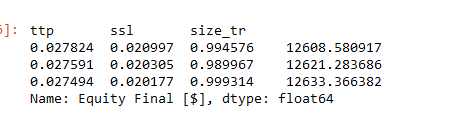

In [31]:
class CustomStrategy(SignalStrategy):
    
    ssl = 0.046
    ttp = 0.054
    size_tr = 0.9
    def init(self):
        
        super().init()
        self.rsi = self.I(lambda x: data['dec_mfi'], 'mfi')

    def next(self):
        
        close = self.data.Close
        signal = self.rsi
        #prev_signal = self.rsi[-1]
        
        upper_tp = close*(1+self.ttp) 
        upper_sl = close*(1+self.ssl) 
        lower_sl = close*(1-self.ssl)   
        lower_tp = close*(1-self.ttp)
        
        #size_transaction = 0.85
        
        #if not signal == prev_signal:
        if signal == 1 and not self.position.is_long:
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 and not self.position.is_short:
            self.sell(size=self.size_tr, sl = upper_sl, tp=lower_tp)
                
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, 
              trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
stats

#optymalizacja parametrow
stats_skopt, heatmap, optimize_result = bt.optimize(ttp=[0.01, 0.1],
           ssl=[0.01, 0.1],
           size_tr=[0.4, 1], 
           maximize='Equity Final [$]',
           method='skopt',
           max_tries=1000,
           random_state=10,
           return_heatmap=True,
           return_optimization=True)
heatmap.sort_values().iloc[-3:]

Backtest.optimize:   0%|          | 0/1000 [00:00<?, ?it/s]

ttp       ssl       size_tr 
0.027772  0.023394  0.999549    12602.909756
0.027642  0.020157  0.984607    12609.150777
0.027494  0.020177  0.999314    12633.366382
Name: Equity Final [$], dtype: float64

In [27]:
stats_skopt

Start                     2019-01-04 00:00:00
End                       2024-05-03 00:00:00
Duration                   1946 days 00:00:00
Exposure Time [%]                    7.675112
Equity Final [$]                 12633.366382
Equity Peak [$]                  12633.366382
Return [%]                          26.333664
Buy & Hold Return [%]              298.960073
Return (Ann.) [%]                    4.487226
Volatility (Ann.) [%]                5.606799
Sharpe Ratio                         0.800319
Sortino Ratio                        1.481408
Calmar Ratio                         0.969923
Max. Drawdown [%]                   -4.626371
Avg. Drawdown [%]                   -1.911447
Max. Drawdown Duration      150 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades                                   27
Win Rate [%]                        62.962963
Best Trade [%]                       3.296812
Worst Trade [%]                     -2.698999
Avg. Trade [%]                    

## Podział na dane testowe i treningowe
#### Przygotowanie danych pod deep learning

In [32]:
# Wybór danych testowych i treningowych
train_data = data[(data.index >= train_start) & (data.index <= train_end)]
test_data = data[(data.index >= test_start) & (data.index <= test_end)]

# Przygotowanie danych
prices_train = train_data["Close"].values.reshape(-1, 1)  # konwersja do tablicy numpy
prices_test = test_data["Close"].values.reshape(-1, 1)

# Przeskalowanie do zakresu [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices_train = scaler.fit_transform(prices_train)
scaled_prices_test = scaler.transform(prices_test)

# Tworzenie sekwencji danych dla modelu LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Określenie długości sekwencji (liczba kroków wstecznych)
sequence_length = 10

# Utworzenie sekwencji danych treningowych i testowych
X_train, y_train = create_sequences(scaled_prices_train, sequence_length)
X_test, y_test = create_sequences(scaled_prices_test, sequence_length)

print("Rozmiar danych treningowych:", X_train.shape, y_train.shape)
print("Rozmiar danych testowych:", X_test.shape, y_test.shape)

Rozmiar danych treningowych: (1246, 10, 1) (1246, 1)
Rozmiar danych testowych: (76, 10, 1) (76, 1)


## LSTM

In [33]:
# Model LSTM z hiperparametryzacją
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Tworzenie
input_shape = (X_train.shape[1], X_train.shape[2])  # Kształt danych wejściowych dla modelu LSTM
lstm_model = create_lstm_model(input_shape)

# Trenowanie
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predykcja cen dla danych testowych
predicted_prices = lstm_model.predict(X_test)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0765 - val_loss: 0.0082
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7459e-04 - val_loss: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7404e-04 - val_loss: 9.6903e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.2283e-04 - val_loss: 0.0012
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 9.3991e-04
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.2344e-04 - val_loss: 0.0012
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6860e-04 - val_loss: 0.0014
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5948e-04 - val_loss: 0.0015
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.7342e-04 - val_loss: 0.0016
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.9369e-04 - val_loss: 0.0011
Epoch 12/100

Epoch 66/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3253e-04 - val_loss: 6.0797e-04
Epoch 67/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8351e-04 - val_loss: 0.0010
Epoch 68/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7921e-04 - val_loss: 4.9983e-04
Epoch 69/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8869e-04 - val_loss: 5.1343e-04
Epoch 70/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3757e-04 - val_loss: 7.3508e-04
Epoch 71/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4626e-04 - val_loss: 4.3597e-04
Epoch 72/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9628e-04 - val_loss: 4.3152e-04
Epoch 73/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1139e-04 - val_loss: 5.5949e-04
Epoch 74/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5259e-04 - val_loss: 4.7311e-04
Epoch 75/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1672e-04 - val_loss: 6.3149e-04
Epoch 76/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

In [34]:
mse = mean_squared_error(y_test, predicted_prices)
print("Mean Squared Error (MSE) na danych testowych:", mse.round(5))

Mean Squared Error (MSE) na danych testowych: 0.00039


In [35]:
predicted_prices_unscaled = scaler.inverse_transform(predicted_prices)

In [36]:
# Dodanie przewidywanych cen do testowych danych
test_data['Predicted_Close'] = np.nan
test_data['Predicted_Close'].iloc[sequence_length:] = predicted_prices_unscaled.flatten()

# Tworzenie sygnałów
test_data['Signal'] = 0
test_data['Signal'][sequence_length:] = np.where(test_data['Predicted_Close'][sequence_length:] > test_data['Close'][sequence_length:], 1, -1)


In [37]:
# Przygotowanie danych do backtestingu

data_for_backtest = pd.DataFrame(index=test_data.index)
data_for_backtest['Open'] = test_data['Open']
data_for_backtest['High'] = test_data['High']
data_for_backtest['Low'] = test_data['Low']
data_for_backtest['Close'] = test_data['Close']
data_for_backtest['Predicted'] = test_data['Predicted_Close']

In [38]:
class LSTMStrategy(Strategy):
    def init(self):
        self.predicted = self.data.Predicted

    def next(self):
        idx = len(self.data) - 1  # Pobranie aktualnego indeksu
        if self.predicted[idx] > self.data.Close[-1]:
            self.buy()
        elif self.predicted[idx] < self.data.Close[-1]:
            self.sell()



In [40]:
bt = Backtest(data_for_backtest, LSTMStrategy, cash=10000, commission=.002)
stats = bt.run()
bt.plot()
stats

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   87.209302
Equity Final [$]                 10114.799817
Equity Peak [$]                  10921.663847
Return [%]                           1.147998
Buy & Hold Return [%]                9.650284
Return (Ann.) [%]                    3.401305
Volatility (Ann.) [%]               19.679697
Sharpe Ratio                         0.172833
Sortino Ratio                        0.252957
Calmar Ratio                         0.371108
Max. Drawdown [%]                   -9.165272
Avg. Drawdown [%]                   -2.935648
Max. Drawdown Duration       43 days 00:00:00
Avg. Drawdown Duration       15 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       2.490821
Worst Trade [%]                      2.490821
Avg. Trade [%]                    

In [42]:

class LSTMCustomStrategy(SignalStrategy):
    ssl = 0.014294
    ttp = 0.029230
    size_tr = 0.970131

    def init(self):
        super().init()
        self.signal = self.I(lambda x: test_data['Signal'], 'signal')

    def next(self):
        close = self.data.Close
        signal = self.signal
        upper_tp = close * (1 + self.ttp)
        upper_sl = close * (1 + self.ssl)
        lower_sl = close * (1 - self.ssl)
        lower_tp = close * (1 - self.ttp)

        if signal == 1 and not self.position.is_long:
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 and not self.position.is_short:
            self.sell(size=self.size_tr, sl=upper_sl, tp=lower_tp)

# Przeprowadzenie backtestu
bt = Backtest(test_data, LSTMCustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

# Optymalizacja parametrów
stats_skopt, heatmap, optimize_result = bt.optimize(
    ttp=[0.01, 0.1],
    ssl=[0.01, 0.1],
    size_tr=[0.4, 1], 
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=1000,
    random_state=10,
    return_heatmap=True,
    return_optimization=True
)
heatmap.sort_values().iloc[-3:]


Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   87.209302
Equity Final [$]                 11787.548701
Equity Peak [$]                  12089.760656
Return [%]                          17.875487
Buy & Hold Return [%]                9.650284
Return (Ann.) [%]                   61.915142
Volatility (Ann.) [%]               25.681016
Sharpe Ratio                          2.41093
Sortino Ratio                        7.301187
Calmar Ratio                        10.500174
Max. Drawdown [%]                   -5.896582
Avg. Drawdown [%]                   -1.765526
Max. Drawdown Duration       26 days 00:00:00
Avg. Drawdown Duration        8 days 00:00:00
# Trades                                   43
Win Rate [%]                        65.116279
Best Trade [%]                       3.669188
Worst Trade [%]                     -2.709969
Avg. Trade [%]                    

Backtest.optimize:   0%|          | 0/1000 [00:00<?, ?it/s]

ttp       ssl       size_tr 
0.071610  0.016344  0.999770    11500.039787
0.079881  0.017022  0.999005    11505.347478
0.080351  0.016645  0.995813    11519.375940
Name: Equity Final [$], dtype: float64

In [43]:
stats_skopt

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   87.209302
Equity Final [$]                  11519.37594
Equity Peak [$]                  11984.237257
Return [%]                          15.193759
Buy & Hold Return [%]                9.650284
Return (Ann.) [%]                   51.356513
Volatility (Ann.) [%]               23.634509
Sharpe Ratio                         2.172946
Sortino Ratio                        5.414183
Calmar Ratio                        10.915512
Max. Drawdown [%]                   -4.704911
Avg. Drawdown [%]                   -1.615593
Max. Drawdown Duration       33 days 00:00:00
Avg. Drawdown Duration        8 days 00:00:00
# Trades                                   24
Win Rate [%]                        83.333333
Best Trade [%]                       7.200196
Worst Trade [%]                     -4.987095
Avg. Trade [%]                    

In [117]:
class RLAgent:
    def __init__(self, lstm_model, mfi_data):
        self.lstm_model = lstm_model
        self.mfi_data = mfi_data
    
    def make_decision(self, current_price, current_mfi):
        # Przekształcenie current_price w jednoelementową tablicę numpy
        current_price = np.array([current_price]).reshape(1, 1, 1)
        
        lstm_prediction = self.lstm_model.predict(current_price)
        lstm_prediction = np.squeeze(lstm_prediction)
        current_mfi = np.squeeze(current_mfi)
        
        decisions = []
        current_price = current_price[0][-1][0]
        current_mfi = current_mfi
        
        if lstm_prediction > current_price and current_mfi > 80:
            decisions.append(-1)
        elif lstm_prediction < current_price and current_mfi < 20:
            decisions.append(1)
        else:
            decisions.append(0)
        return decisions


In [123]:
# Tworzenie sekwencji danych dla modelu LSTM
def create_sequences(data, mfi_data, sequence_length):
    X, y, mfi = [], [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
        mfi.append(mfi_data[i+sequence_length])
    return np.array(X), np.array(y), np.array(mfi)

# Pobranie danych MFI dla treningowych danych
mfi_data_train = train_data['MFI'].values

# Określenie długości sekwencji (liczba kroków wstecznych)
sequence_length = 10

# Utworzenie sekwencji danych treningowych
X_train, y_train, mfi_train = create_sequences(scaled_prices_train, mfi_data_train, sequence_length)

# Przykładowe użycie agenta do podejmowania decyzji
agent = RLAgent(lstm_model, mfi_train)

# Przykładowe użycie agenta do podejmowania decyzji
current_price = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])
current_mfi = X_test[-1].reshape(1, X_test.shape[1])[:, -1]  # Ostatnia wartość MFI
decision = agent.make_decision(current_price, current_mfi)
print("Decyzja:", decision)

ValueError: cannot reshape array of size 10 into shape (1,1,1)

In [121]:
class LSTMStrategy(Strategy):
    def init(self):
        # Inicjalizacja modelu i agenta
        self.lstm_model = lstm_model
        self.agent = RLAgent(self.lstm_model, mfi_train)

    def next(self):
        # Pobranie aktualnej ceny i wskaźnika MFI
        current_price = self.data.Close[-1]
        current_mfi = self.data.MFI[-1]

        # Podejmowanie decyzji przez agenta
        decision = self.agent.make_decision(current_price, current_mfi)

        # Wykonanie decyzji agenta
        if decision == 1:
            self.buy()
        elif decision == -1:
            self.sell()


In [122]:
# Dopasowanie 'scaler' do danych treningowych
scaler.fit(train_data[['Open', 'High', 'Low', 'Close']])

# Przeskalowanie 'Open', 'High', 'Low' i 'Close' w danych testowych
test_data_scaled = test_data.copy()
test_data_scaled[['Open', 'High', 'Low', 'Close']] = scaler.transform(test_data[['Open', 'High', 'Low', 'Close']])

# Utworzenie DataFrame z przeskalowanymi danymi testowymi
df_test = test_data_scaled[['Open', 'High', 'Low', 'Close', 'MFI']]

# Teraz możesz użyć df_test do backtestu
bt = Backtest(df_test, LSTMStrategy, cash=10000, commission=.002)

# Uruchomienie backtestu
output = bt.run()
print(output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

In [125]:
class RLAgent:
    def __init__(self, lstm_model, mfi_data):
        self.lstm_model = lstm_model
        self.mfi_data = mfi_data
    
    def make_decision(self, current_sequence, current_mfi):
        # Przekształcenie current_sequence w jednoelementową tablicę numpy
        current_sequence = np.array([current_sequence]).reshape(1, sequence_length, 1)
        
        lstm_prediction = self.lstm_model.predict(current_sequence)
        lstm_prediction = np.squeeze(lstm_prediction)
        current_mfi = np.squeeze(current_mfi)
        
        decisions = []
        current_price = current_sequence[0][-1][0]
        current_mfi = current_mfi
        
        if lstm_prediction > current_price and current_mfi > 80:
            decisions.append(-1)
        elif lstm_prediction < current_price and current_mfi < 20:
            decisions.append(1)
        else:
            decisions.append(0)
        return decisions

class LSTMStrategy(Strategy):
    def init(self):
        # Inicjalizacja modelu i agenta
        self.lstm_model = lstm_model
        self.agent = RLAgent(self.lstm_model, mfi_train)

    def next(self):
        # Pobranie aktualnej ceny i wskaźnika MFI
        current_sequence = self.data.Close[-sequence_length:]
        current_mfi = self.data.MFI[-1]

        # Podejmowanie decyzji przez agenta
        decision = self.agent.make_decision(current_sequence, current_mfi)

        # Wykonanie decyzji agenta
        if decision == 1:
            self.buy()
        elif decision == -1:
            self.sell()

# Teraz możesz użyć df_test do backtestu
bt = Backtest(df_test, LSTMStrategy, cash=10000, commission=.002)

# Uruchomienie backtestu
output = bt.run()
print(output)


ValueError: cannot reshape array of size 2 into shape (1,10,1)